# Unambiguous Notebook Analyses (RQ6)

This notebooks analyzes the selection of unambiguous notebooks. These analyses answer RQ6.

In [1]:
import sys
sys.path.insert(0, '../archaeology')


import pandas as pd
from matplotlib import pyplot as plt


import analysis_helpers, importlib
importlib.reload(analysis_helpers)
from analysis_helpers import boxplot_distribution
from analysis_helpers import distribution_with_boxplot, savefig, fig
from analysis_helpers import relative_var, var
from analysis_helpers import dbmt, DBMT, print_relative_var_group
from analysis_helpers import load_vars, group_run, dbmt_relative_var
from db import connect

%matplotlib inline

## Query

Select notebooks that are:
- valid
  
  ```NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
  AND n.processed & 15 = 0 AND n.skip & (1024 + 512) = 0```


- non-duplicated
  
  ```n.skip & (1024 + 512 + 128) = 0```
  
- executed

  ```n.max_execution_count > -0```
  
- unambiguous

  ```n.processing_cells = 0 AND n.unambiguous = 1```

In [2]:
%%time
with connect() as session:
    print("Query Notebooks")
    query = ("""
        SELECT n.*, n.id as notebook_id
        FROM notebooks n
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.max_execution_count > -0
        AND n.processing_cells = 0
        AND n.unambiguous = 1
    """)
    notebooks = pd.read_sql(query, session.connection())
    print("Unambiguous Notebooks:", len(notebooks))

Query Notebooks
Unambiguous Notebooks: 802474
CPU times: user 9.96 s, sys: 1.17 s, total: 11.1 s
Wall time: 18.3 s


## Unordered

In [3]:
dbmt_relative_var(
    "Unordered notebooks: {}", "a5_unordered_notebooks", 
    dbmt(notebooks[notebooks["unordered"] > 0]), dbmt(notebooks)
)

Unordered notebooks: a5_unordered_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"292,469 (36.45%)",None,None,None,None,None
1,(Sample),sd_,20 (37.74%),0.01%,0.00%,103.54%,(+) 3.54%,1.29%
2,(Popular),td_,"6,276 (22.37%)",2.15%,0.78%,61.37%,(-) 38.63%,-14.08%


## Skips (Hidden States)


In [4]:
dbmt_relative_var(
    "Notebooks with skips: {}", "a5_notebooks_with_skips",
    dbmt(notebooks[notebooks["execution_skips_total"] > 0]), dbmt(notebooks)
)

Notebooks with skips: a5_notebooks_with_skips


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"616,974 (76.88%)",None,None,None,None,None
1,(Sample),sd_,37 (69.81%),0.01%,0.00%,90.80%,(-) 9.20%,-7.07%
2,(Popular),td_,"16,146 (57.54%)",2.62%,2.01%,74.84%,(-) 25.16%,-19.34%



Max 220
Distribution(min=0, q1=1.0, median=2.0, q3=4.0, max=220)


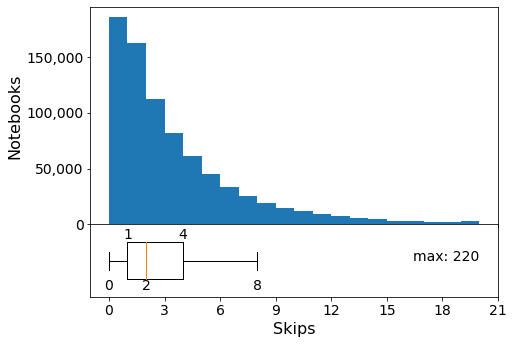

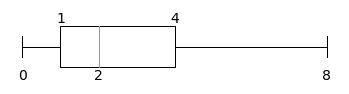

(Sample) 
Max 19
Distribution(min=0, q1=0.0, median=2.0, q3=5.0, max=19)


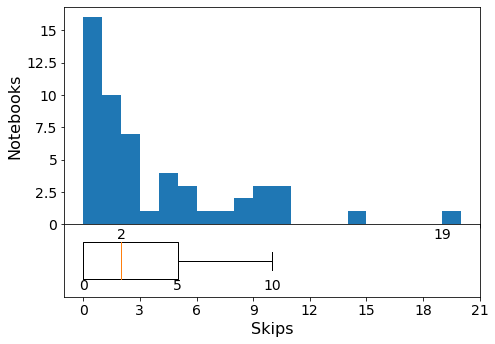

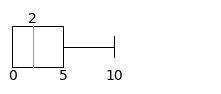

(Popular) 
Max 157
Distribution(min=0, q1=0.0, median=1.0, q3=3.0, max=157)


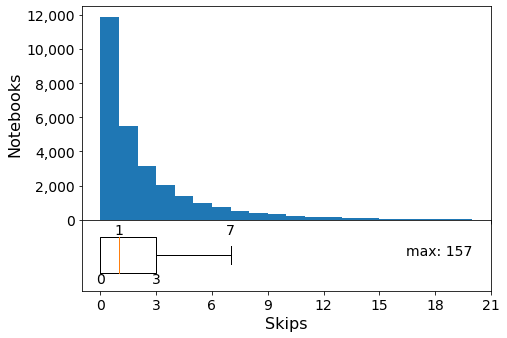

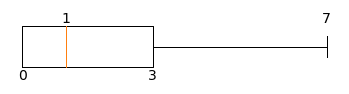

[None, None, None]

In [5]:
def calculate_notebook_skips(notebooks, prefix):
    column = notebooks["execution_skips_total"]
    with savefig(prefix + "a5_notebook_skips_full", 6, 5):
        distribution = distribution_with_boxplot(column, 0, 20, 3, "Notebooks", "Skips",  True)
        print("Max", var(prefix + "a5_notebook_skips_max", distribution.max, "{:g}"))
        print(distribution)
    cfig = plt.gcf()
    display(cfig)
    plt.close(cfig)
    with savefig(prefix + "a5_notebook_skips", 5, 1.25):
        boxplot_distribution(column, 0, 20, 3, "Notebooks", "Skips",  True)
        
group_run(dbmt(notebooks), DBMT, calculate_notebook_skips)

## Skip sizes


Distribution(min=1, q1=6.0, median=21.0, q3=61.0, max=10995)


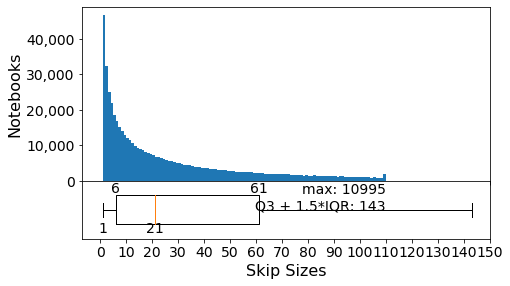

(Sample) 
Distribution(min=1, q1=5.0, median=20.0, q3=52.0, max=242)


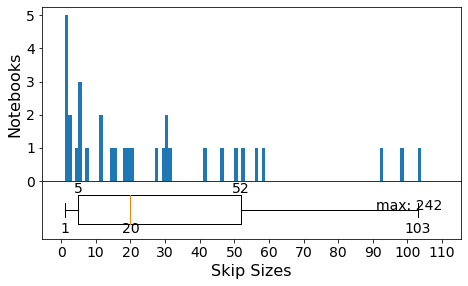

(Popular) 
Distribution(min=1, q1=3.0, median=12.0, q3=35.0, max=2622)


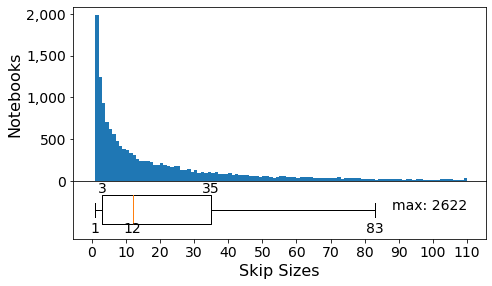

In [6]:
def calculate_skip_sizes(notebooks, prefix):
    select = notebooks[notebooks["execution_skips_total"] > 0]
    column = select["execution_skips_size"]
    with fig(prefix + "a5_notebook_skips_sizes", 6, 4):
        distribution = distribution_with_boxplot(column, 0, 110, 10, "Notebooks", "Skip Sizes",  True)
        print(distribution)
    return column, select
    
skip_sizes_select = group_run(dbmt(notebooks), DBMT, calculate_skip_sizes)

In [7]:
def skip_average(skip_sizes_select, prefix):
    skip_sizes, select = skip_sizes_select
    print("Number of executions by skip, on average:", var(
        prefix + "a5_skip_average",
        skip_sizes.sum()
        / select["execution_skips_total"].sum(),
        "{:.2f}"
    ))
group_run(skip_sizes_select, DBMT, skip_average, plot=False);

Number of executions by skip, on average: 12.83
Number of executions by skip, on average: 8.76
Number of executions by skip, on average: 9.84


In [8]:
dbmt_relative_var(
    "Notebooks with skips in the middle: {}", "a5_notebooks_with_skips_in_the_middle", 
    dbmt(notebooks[notebooks["execution_skips_middle_total"] > 0]), dbmt(notebooks)
)

Notebooks with skips in the middle: a5_notebooks_with_skips_in_the_middle


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"530,827 (66.15%)",None,None,None,None,None
1,(Sample),sd_,33 (62.26%),0.01%,0.00%,94.13%,(-) 5.87%,-3.88%
2,(Popular),td_,"13,424 (47.84%)",2.53%,1.67%,72.32%,(-) 27.68%,-18.31%



Distribution(min=0, q1=0.0, median=1.0, q3=4.0, max=219)


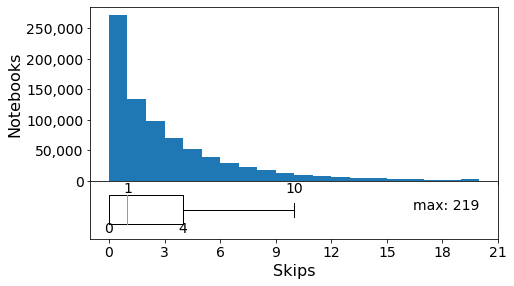

(Sample) 
Distribution(min=0, q1=0.0, median=1.0, q3=4.0, max=18)


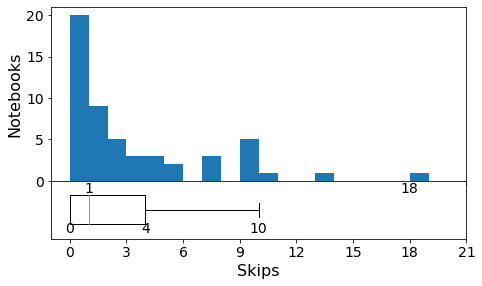

(Popular) 
Distribution(min=0, q1=0.0, median=0.0, q3=2.0, max=156)


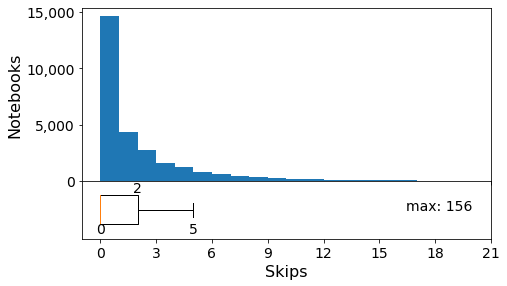

In [9]:
def skips_middle(notebooks, prefix):
    column = notebooks["execution_skips_middle_total"]
    with fig(prefix + "a5_notebook_skips_middle", 6, 4):
        distribution = distribution_with_boxplot(column, 0, 20, 3, "Notebooks", "Skips",  True)
        print(distribution)
        
group_run(dbmt(notebooks), DBMT, skips_middle);

## Skip sizes in the middle


Distribution(min=1, q1=5.0, median=16.0, q3=49.0, max=10887)
Number of executions by skip in the middle, on average: 10.33


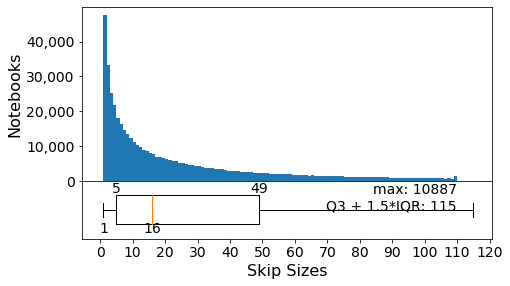

(Sample) 
Distribution(min=1, q1=4.0, median=18.0, q3=52.0, max=221)
Number of executions by skip in the middle, on average: 7.41


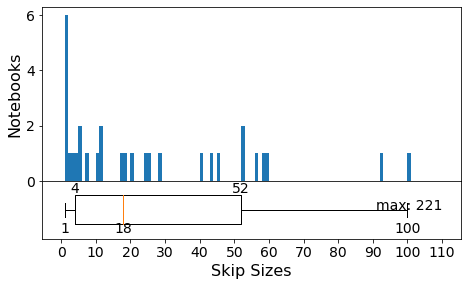

(Popular) 
Distribution(min=1, q1=3.0, median=9.0, q3=29.0, max=2622)
Number of executions by skip in the middle, on average: 8.31


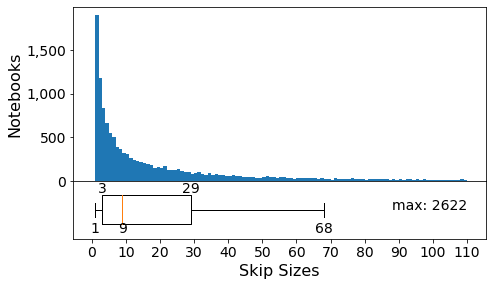

In [10]:
def skips_sizes_middle(notebooks, prefix):
    with_skips_middle = notebooks[notebooks["execution_skips_middle_total"] > 0]
    skip_sizes_middle = column = with_skips_middle["execution_skips_middle_size"]
    with fig(prefix + "a5_notebook_skips_sizes_middle", 6, 4):
        distribution = distribution_with_boxplot(column, 0, 110, 10, "Notebooks", "Skip Sizes",  True)
        print(distribution)
    print("Number of executions by skip in the middle, on average:", var(
        prefix + "a5_skip_average_middle",
        skip_sizes_middle.sum()
        / with_skips_middle["execution_skips_middle_total"].sum(),
        "{:.2f}"
    ))
group_run(dbmt(notebooks), DBMT, skips_sizes_middle);

This notebook analyzed general characteristics of notebooks and cells to answer RQ6 for the paper. There are other analyses that did no make into the paper. For those, refer to E2.Notebooks and E6.Cells.